# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [44]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 55
ROUNDS = 100
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

# Get IQ data RESETS

In [53]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.3

# stim_circ = simulator.get_stim_circuit(noise_list=NOISE_LIST)
# print(simulator.get_counts(SHOTS, simulator.stim_circ))
IQ_data = simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

100%|██████████| 10000/10000 [05:50<00:00, 28.52it/s]


# Get IQ data NO RESETS

In [54]:
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = not _RESETS, other_date=OTHER_DATE)

# stim_circ = simulator.get_stim_circuit(noise_list=NOISE_LIST)
# print(simulator.get_counts(SHOTS, simulator.stim_circ))
IQ_data_nr = simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)
IQ_data_extreme_nr = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_list=NOISE_LIST)

 11%|█         | 1069/10000 [00:38<05:17, 28.09it/s]


KeyboardInterrupt: 

# Decode IQ data

In [55]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

In [56]:
import cpp_soft_info

_DETAILED = False

matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                            p_offset = 1, p_multiplicator = 1, _ntnn_edges = not _RESETS)

matching = pymatching.Matching.from_detector_error_model(model)
result_nr = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_nr,
                                             ROUNDS, int(LOGICAL), False, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=True, _bimodal=False, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print("num_errors:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
print("num_errors NR:", result_nr.num_errors, "out of", len(IQ_data_extreme), "shots for _RESETS =", False)

KeyboardInterrupt: 

# Plot the results

In [24]:
print("\nIQ:", result.indices)
print("\nIQ NR:", result_nr.indices)


IQ: [42, 65, 616, 825, 934, 943, 948, 997, 1029, 1049, 1076, 1132, 1335, 1551, 1578, 1588, 1614, 1664, 1792, 1807, 1889, 1897, 1954, 2115, 2144, 2274, 2327, 2640, 2817, 2824, 2850, 2901, 3015, 3120, 3137, 3258, 3316, 3467, 3516, 3746, 3822, 3863, 3896, 3928, 3960, 4053, 4127, 4188, 4291, 4452, 4461, 4462, 4507, 4536, 4592, 4674, 4715, 4717, 4749, 4840, 4871, 4935, 5052, 5183, 5224, 5258, 5265, 5386, 5404, 5425, 5451, 5532, 5586, 5594, 5789, 5976, 6095, 6200, 6222, 6240, 6459, 6470, 6518, 6526, 6548, 6576, 6699, 6714, 6841, 6899, 6953, 6957, 7016, 7157, 7233, 7276, 7311, 7371, 7691, 7710, 7939, 7974, 8212, 8502, 8507, 8527, 8594, 8651, 8676, 8777, 8790, 8896, 8992, 9104, 9142, 9156, 9262, 9297, 9370, 9378, 9523, 9634, 9647, 9693, 9728, 9744, 9828, 9850, 9863, 9877, 9984]

IQ NR: [42, 65, 66, 751, 768, 948, 997, 1029, 1049, 1076, 1095, 1198, 1335, 1471, 1578, 1588, 1807, 1889, 1897, 1954, 2115, 2274, 2305, 2327, 2342, 2591, 2640, 2677, 2824, 2850, 2901, 2984, 3015, 3059, 3120, 3137, 318

----- RESETS -----


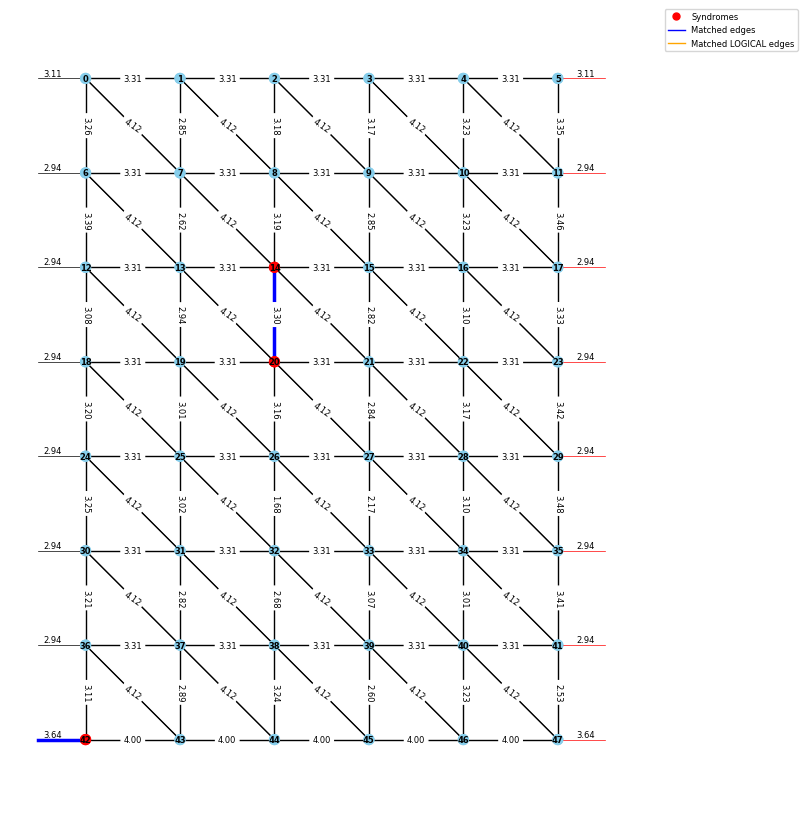

-----NO RESETS-----


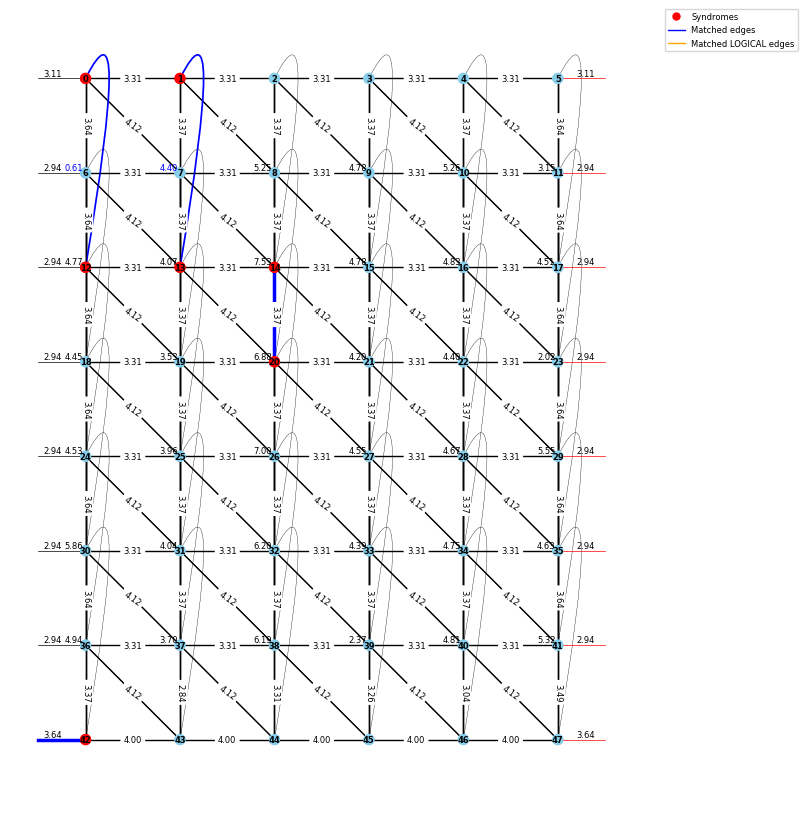

In [36]:
from soft_info import draw_matching_graph


index = 8100

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result
details = to_be_result.error_details[index]
print(f"----- RESETS -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_nr
details = to_be_result.error_details[index]
print(f"-----NO RESETS-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [25]:
informed_not_in_iq = sorted(set(result_nr.indices) - set(result.indices))
print("indices that are in NR but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_nr.indices))
print("indices that are in IQ but not in NR with len:", len(iq_not_in_informed))
print(iq_not_in_informed)


indices that are in NR but not in IQ with len: 49
[66, 751, 768, 1095, 1198, 1471, 2305, 2342, 2591, 2677, 2984, 3059, 3183, 3253, 3340, 3440, 3844, 3886, 4268, 4621, 4693, 5176, 5332, 5365, 5723, 5785, 5848, 5925, 5938, 6180, 6234, 6914, 7181, 7378, 7528, 7657, 8116, 8225, 8644, 8677, 8841, 8916, 8987, 9250, 9336, 9357, 9599, 9814, 9879]
indices that are in IQ but not in NR with len: 48
[616, 825, 934, 943, 1132, 1551, 1614, 1664, 1792, 2144, 2817, 3258, 3822, 3928, 4127, 4188, 4291, 4452, 4462, 4536, 4871, 5183, 5404, 5451, 5532, 5586, 5594, 5976, 6200, 6470, 6518, 6576, 6714, 7276, 7311, 7691, 8212, 8507, 8527, 8594, 8676, 8777, 8790, 8896, 9104, 9262, 9728, 9984]


# Analyse specific shots

{'0000000 000010 000000 000000 001000 000000 000000 000000': 1}


100%|██████████| 169/169 [00:00<00:00, 2286572.18it/s]

mean time edge weight: 3.4590393702189126

[(4, 16), (27, 15), (18, 30), (21, 33), (24, 25), (26, 38), (46, 45), (47, 35), (46, 47), (34, 41), (36, -1), (42, -1)]
-----IQ-----


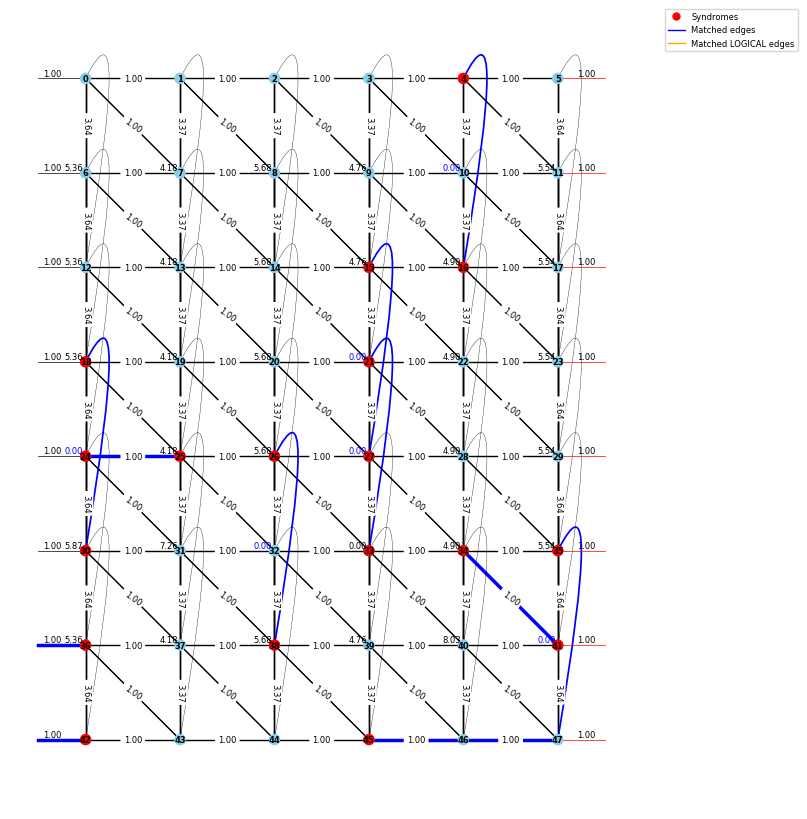

In [ ]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)